In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
%config Completer.use_jedi = False
import os
import time

import numpy as np
import pandas as pd
import seaborn as sns

sns.set()
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from joblib import Parallel, delayed
from matplotlib import pyplot as plt
from matplotlib.widgets import MultiCursor, Cursor
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from scipy.interpolate import InterpolatedUnivariateSpline, interp1d
from scipy.signal import argrelmax, argrelmin, find_peaks
from sklearn.linear_model import LinearRegression
from sidecar import Sidecar

import sys
sys.path.append("..")
from src import definitions as defs
from src import features, models

In [2]:
wdir = defs.ROOT / "data"

In [5]:
freq = "30 min"
n_per_hour = pd.Timedelta("1 hour") / pd.Timedelta(freq)
data = pd.read_csv(wdir / "raw" / "mongla_tides.csv", index_col="datetime", parse_dates=True, infer_datetime_format=True)
data = data.reindex(pd.date_range(start=data.index[0], end=data.index[-1], freq=freq, name="datetime"))
data.elevation = data.elevation.interpolate(method="time", limit=1, limit_direction="both")

In [6]:
data[["high", "low"]] = False
distance = n_per_hour * 8
hi = find_peaks(x=data.elevation.values, distance=distance)[0]
lo = find_peaks(x=data.elevation.values * -1, distance=distance)[0]
data.loc[data.iloc[hi].index, "high"] = True
data.loc[data.iloc[lo].index, "low"] = True

In [7]:
dt = pd.Timedelta("30 days")
stds = 3
r_high = data.elevation.loc[data.high == True].rolling(window=dt, center=True)
top = r_high.mean() + stds * r_high.std()
bot = r_high.mean() -  stds * r_high.std()
highs_for_roll = data.loc[data.high == True].loc[data.loc[data.high == True].elevation.between(bot, top)].elevation

r_low = data.elevation.loc[data.low == True].rolling(window=dt, center=True)
top = r_low.mean() + stds * r_low.std()
bot = r_low.mean()  -  stds * r_low.std()
lows_for_roll = data.loc[data.low == True].loc[data.loc[data.low == True].elevation.between(bot, top)].elevation

In [8]:
highs_excl = data.loc[data.high == True].loc[data.loc[data.high == True].index.difference(other=highs_for_roll.index)]
lows_excl = data.loc[data.low == True].loc[data.loc[data.low == True].index.difference(other=lows_for_roll.index)]

In [9]:
data["high_roll"] = highs_for_roll.rolling(window=pd.Timedelta("27h"), center=True).mean().reindex(index=data.index).interpolate(method="time", limit_direction="both")
data["low_roll"] = lows_for_roll.rolling(window=pd.Timedelta("27h"), center=True).mean().reindex(index=data.index).interpolate(method="time", limit_direction="both")
data["amp_roll"] = data.high_roll - data.low_roll

In [10]:
window = pd.Timedelta("27 hour")
exog = (data.index - data.index[0]).total_seconds().astype(int)
frac = window / pd.Timedelta(freq) / len(data)
delta = window * 500 / pd.Timedelta(freq)
endogs = (data.high_roll.values, data.low_roll.values)

high_smooth, low_smooth = Parallel(n_jobs=2)(delayed(sm.nonparametric.lowess)(endog=endog, exog=exog, frac=frac, delta=delta, is_sorted=True) for endog in endogs)

ValueError: buffer source array is read-only

In [ ]:
data.loc[pd.TimedeltaIndex(list(zip(*high_smooth))[0], unit="s") + data.index[0], "high_smooth"] = list(zip(*high_smooth))[1]
data.loc[pd.TimedeltaIndex(list(zip(*low_smooth))[0], unit="s") + data.index[0], "low_smooth"] = list(zip(*low_smooth))[1]
data["amp_smooth"] = data.high_smooth - data.low_smooth

In [ ]:
data[["spring", "neap"]] = False
distance = n_per_hour * 24 * 11 # search distance in hours
hi = find_peaks(x=data.amp_smooth.values, distance=distance, height=3.0)[0]
lo = find_peaks(x=data.amp_smooth.values * -1, distance=distance, height=-2.5)[0]
data.loc[data.iloc[hi].index, "spring"] = True
data.loc[data.iloc[lo].index, "neap"] = True

In [ ]:
start = pd.to_datetime("1999-04-01")
end = start + pd.Timedelta("30D")

pdata = data.loc[start:end].reset_index()

fig = plt.figure(figsize=(10, 5))
ax = fig.subplots()

sns.lineplot(data=pdata, x="datetime", y="elevation", color="cornflowerblue", alpha=0.3, ax=ax)
sns.lineplot(data=pdata, x="datetime", y="high_smooth", color="green", alpha=0.3, ax=ax)
sns.lineplot(data=pdata, x="datetime", y="low_smooth", color="red", alpha=0.3, ax=ax)
sns.lineplot(data=pdata, x="datetime", y="amp_smooth", color="black", alpha=0.3, ax=ax)

sns.scatterplot(data=pdata.loc[pdata.high == True], x="datetime", y="elevation", color="green", s=15, ax=ax, zorder=15)
sns.scatterplot(data=pdata.loc[pdata.low == True], x="datetime", y="elevation", color="red", s=15, ax=ax, zorder=15)

sns.scatterplot(data=highs_excl.loc[start:end].reset_index(), x="datetime", y="elevation", color="black", marker="X", s=50)
sns.scatterplot(data=lows_excl.loc[start:end].reset_index(), x="datetime", y="elevation", color="black", marker="X", s=50)
sns.lineplot(data=r_high.mean().loc[start:end], color="green", alpha=0.3, ax=ax)
sns.lineplot(data=r_low.mean().loc[start:end], color="red", alpha=0.3, ax=ax)

for loc in pdata.loc[pdata.spring == True].datetime:
    ax.axvline(x=loc, color="black", linestyle="dotted", alpha=0.5)
    ax.text(x=loc, y=ax.get_ylim()[1], s="S", rotation=0, ha="center", va="bottom")

for loc in pdata.loc[pdata.neap == True].datetime:
    ax.axvline(x=loc, color="black", linestyle="dotted", alpha=0.5)
    ax.text(x=loc, y=ax.get_ylim()[1], s="N", rotation=0, ha="center", va="bottom")

title = "Mongla Tidal Data from {} to {}".format(start.strftime("%b %Y"), end.strftime("%b %Y"))
xlabel = ""
ylabel = "Elevation (m)"
rotation = 0

locator = locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)

ax.xaxis.set(major_locator=locator, major_formatter=formatter)
ax.tick_params(axis='x', labelrotation=rotation)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.set_title(label=title, pad=20)
ax.set_xlim(start, end)
fig.tight_layout()

In [13]:
subset = data.loc["1998":"2009"].copy()
subset.elapsed = subset.index - subset.index[0]

# nodal_amp = 0.045
nodal_freq = 18.61
phase_start = pd.to_datetime("2015-10-01")

# subset["nodal"] = nodal_amp * np.sin(2 * np.pi * ((subset.index - phase_start) / (pd.Timedelta("365.25 days") * nodal_freq)) + np.pi / 2)
# subset["elev_adj"] = subset.elevation - subset.nodal

In [13]:
def lm_tides(data, ref_date, time_unit="365.25 days"):

    x = ((data.index - ref_date) / pd.Timedelta(time_unit)).values.reshape(-1, 1)
    y = data.values.reshape(-1, 1)
    lm = LinearRegression().fit(x, y)

    y_pred = lm.predict(x)

    ts = pd.Series(data=y_pred.flatten(), index=data.index)

    index = ("lm", "coef", "intercept", "TS")
    data = (lm, lm.coef_[0, 0], lm.intercept_[0], ts)

    s = pd.Series(data=data, index=index)

    return(s)

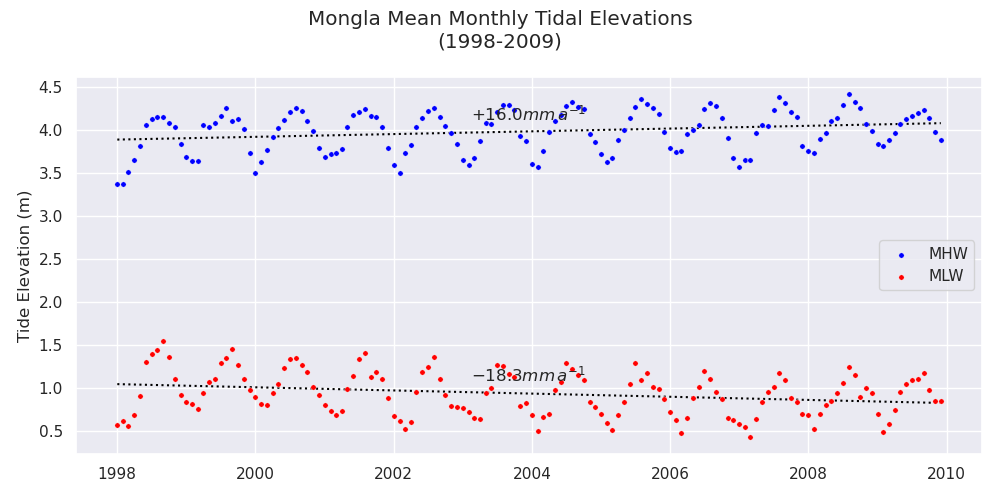

In [27]:
subset = data.loc["1998":"2009"].copy()
subset.elapsed = subset.index - subset.index[0]
nodal_freq = 18.61
phase_start = pd.to_datetime("2015-10-01")

daily = subset.groupby(by=pd.Grouper(freq="D")).agg({"elevation": ["max", "min"]})
daily.columns = daily.columns.droplevel()
monthly = daily.groupby(by=pd.Grouper(freq="MS")).agg("mean").rename(columns={"max": "MHW", "min": "MLW"})
monthly["MW"] = subset.groupby(by=pd.Grouper(freq="MS")).agg({"elevation": "mean"}).rename(columns={"elevation": "MW"})
monthly["MTR"] = monthly.MHW - monthly.MLW

nodal_amp = 0.037 * monthly.MTR.mean()
t = (monthly.index - phase_start) / pd.Timedelta("365.25 days")
w = 2 * np.pi / nodal_freq

monthly["nodal"] = nodal_amp * np.cos(w * t)
monthly["MHW_n"] = monthly.MHW - monthly.nodal / 2
monthly["MLW_n"] = monthly.MLW + monthly.nodal / 2
# monthly = monthly.join(daily.groupby(by=pd.Grouper(freq="MS")).agg("std").rename(columns={"max": "MHW_std", "min": "MLW_std"}))

monthly_lm = monthly.apply(lambda x: lm_tides(data=x, ref_date=subset.index[0], time_unit="365 days"))

fig = plt.figure(figsize=(10, 5))
ax = fig.subplots()

var1 = "MHW_n"
var2 = "MLW_n"

### Original ###

sns.scatterplot(data=monthly.reset_index(), x="datetime", y=var1, color="blue", s=15, ax=ax, zorder=15, label="MHW")
sns.scatterplot(data=monthly.reset_index(), x="datetime", y=var2, color="red", s=15, ax=ax, zorder=15, label="MLW")
# sns.scatterplot(data=monthly.reset_index(), x="datetime", y="MW", color="black", s=15, ax=ax, zorder=15, label="MHW")

sns.lineplot(data=eval("monthly_lm.{}.TS".format(var1)), color="black", linestyle="dotted", ax=ax, zorder=10)
sns.lineplot(data=eval("monthly_lm.{}.TS".format(var2)), color="black", linestyle="dotted", ax=ax, zorder=10)

ax.text(x=eval("monthly_lm.{}.TS.index.mean()".format(var1)), y=eval("monthly_lm.{}.TS.max()".format(var1)), ha="center", va="bottom", zorder=30, s="${:+.1f} mm \, a^{{-1}}$".format(eval("monthly_lm.{}.coef".format(var1)) * 1000), fontsize="medium", fontweight="bold")
ax.text(x=eval("monthly_lm.{}.TS.index.mean()".format(var2)), y=eval("monthly_lm.{}.TS.max()".format(var2)), ha="center", va="bottom", zorder=30, s="${:+.1f} mm \, a^{{-1}}$".format(eval("monthly_lm.{}.coef".format(var2)) * 1000), fontsize="medium", fontweight="bold")

ax.set(xlabel="", ylabel="Tide Elevation (m)")

title = "Mongla Mean Monthly Tidal Elevations\n({}-{})".format(subset.index[0].year, subset.index[-1].year)
fig.suptitle(t=title)

fig.tight_layout()

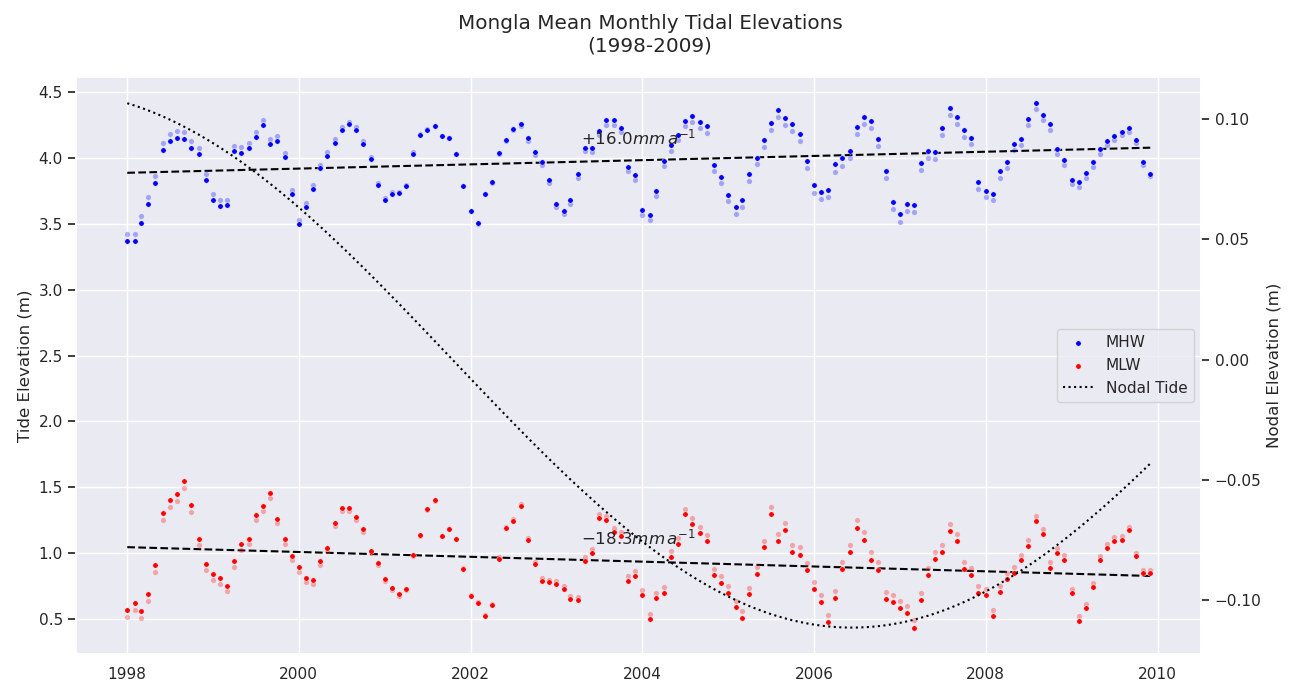

In [28]:
monthly_lm = monthly.apply(lambda x: lm_tides(data=x, ref_date=subset.index[0], time_unit="365.25 days"))

fig = plt.figure(figsize=(13, 7))
ax = fig.subplots()

### Original ###

sns.scatterplot(data=monthly.reset_index(), x="datetime", y="MHW", color="blue", s=15, ax=ax, alpha=0.3, zorder=15)
sns.scatterplot(data=monthly.reset_index(), x="datetime", y="MLW", color="red", s=15, ax=ax, alpha=0.3, zorder=15)

# sns.lineplot(data=monthly_lm.MHW.TS, color="black", linestyle="dotted", ax=ax, zorder=10)
# sns.lineplot(data=monthly_lm.MLW.TS, color="black", linestyle="dotted", ax=ax, zorder=10)

# ax.text(x=monthly_lm.MHW.TS.index.mean(), y=monthly_lm.MHW.TS.max(), ha="center", va="bottom", zorder=30, s="${:+.1f} mm \, a^{{-1}}$".format(monthly_lm.MHW.coef * 1000), fontsize="medium", fontweight="bold")
# ax.text(x=monthly_lm.MLW.TS.index.mean(), y=monthly_lm.MLW.TS.max(), ha="center", va="bottom", zorder=30, s="${:+.1f} mm \, a^{{-1}}$".format(monthly_lm.MLW.coef * 1000), fontsize="medium", fontweight="bold")

### Filtered ###

sns.scatterplot(data=monthly.reset_index(), x="datetime", y="MHW_n", color="blue", s=15, ax=ax, zorder=15, label="MHW")
sns.scatterplot(data=monthly.reset_index(), x="datetime", y="MLW_n", color="red", s=15, ax=ax, zorder=15, label="MLW")

sns.lineplot(data=monthly_lm.MHW_n.TS, color="black", linestyle="dashed", ax=ax, zorder=10)
sns.lineplot(data=monthly_lm.MLW_n.TS, color="black", linestyle="dashed", ax=ax, zorder=10)

ax.text(x=monthly_lm.MHW_n.TS.index.mean(), y=monthly_lm.MHW_n.TS.max(), ha="center", va="bottom", zorder=30, s="${:+.1f} mm \, a^{{-1}}$".format(monthly_lm.MHW_n.coef * 1000), fontsize="medium", fontweight="bold")
ax.text(x=monthly_lm.MLW_n.TS.index.mean(), y=monthly_lm.MLW_n.TS.max(), ha="center", va="bottom", zorder=30, s="${:+.1f} mm \, a^{{-1}}$".format(monthly_lm.MLW_n.coef * 1000), fontsize="medium", fontweight="bold")


### Nodal Signal ###

for a in fig.get_axes():
    aa = a.twinx()
    sns.lineplot(data=monthly.nodal, color="black", ls=":", ax=aa, zorder=1, label="Nodal Tide", legend=False)
    aa.set_ylabel("Nodal Elevation (m)")
    aa.grid(False)

ax.set(xlabel="", ylabel="Tide Elevation (m)")

lines_1, labels_1 = ax.get_legend_handles_labels()
lines_2, labels_2 = aa.get_legend_handles_labels()

lines = lines_1 + lines_2
labels = labels_1 + labels_2

ax.legend(lines, labels, loc=0)

title = "Mongla Mean Monthly Tidal Elevations\n({}-{})".format(subset.index[0].year, subset.index[-1].year)
fig.suptitle(t=title)

fig.tight_layout()

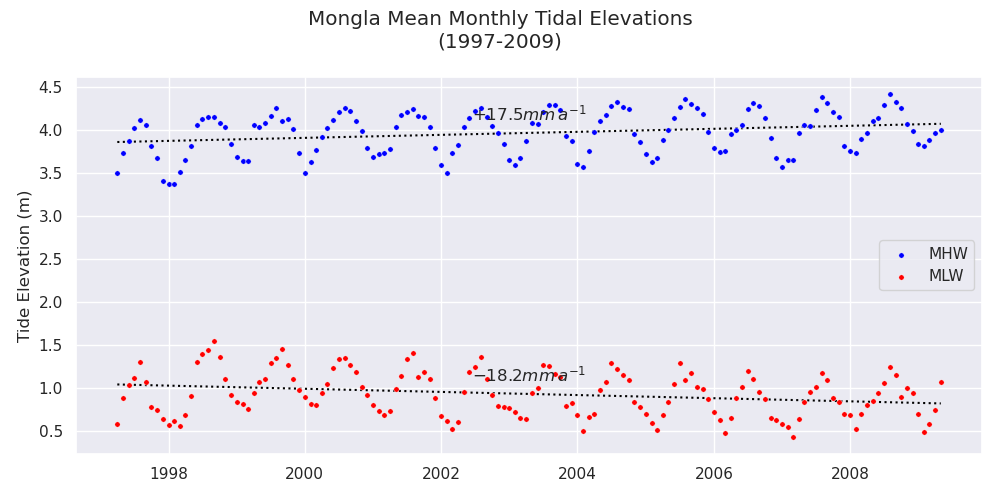

In [19]:
monthly_lm = monthly.apply(lambda x: lm_tides(data=x, ref_date=subset.index[0], time_unit="365.25 days"))

fig = plt.figure(figsize=(10, 5))
ax = fig.subplots()

var1 = "MHW_n"
var2 = "MLW_n"

### Original ###

sns.scatterplot(data=monthly.reset_index(), x="datetime", y=var1, color="blue", s=15, ax=ax, zorder=15, label="MHW")
sns.scatterplot(data=monthly.reset_index(), x="datetime", y=var2, color="red", s=15, ax=ax, zorder=15, label="MLW")

sns.lineplot(data=eval("monthly_lm.{}.TS".format(var1)), color="black", linestyle="dotted", ax=ax, zorder=10)
sns.lineplot(data=eval("monthly_lm.{}.TS".format(var2)), color="black", linestyle="dotted", ax=ax, zorder=10)

ax.text(x=eval("monthly_lm.{}.TS.index.mean()".format(var1)), y=eval("monthly_lm.{}.TS.max()".format(var1)), ha="center", va="bottom", zorder=30, s="${:+.1f} mm \, a^{{-1}}$".format(eval("monthly_lm.{}.coef".format(var1)) * 1000), fontsize="medium", fontweight="bold")
ax.text(x=eval("monthly_lm.{}.TS.index.mean()".format(var2)), y=eval("monthly_lm.{}.TS.max()".format(var2)), ha="center", va="bottom", zorder=30, s="${:+.1f} mm \, a^{{-1}}$".format(eval("monthly_lm.{}.coef".format(var2)) * 1000), fontsize="medium", fontweight="bold")

ax.set(xlabel="", ylabel="Tide Elevation (m)")

title = "Mongla Mean Monthly Tidal Elevations\n({}-{})".format(subset.index[0].year, subset.index[-1].year)
fig.suptitle(t=title)

fig.tight_layout()

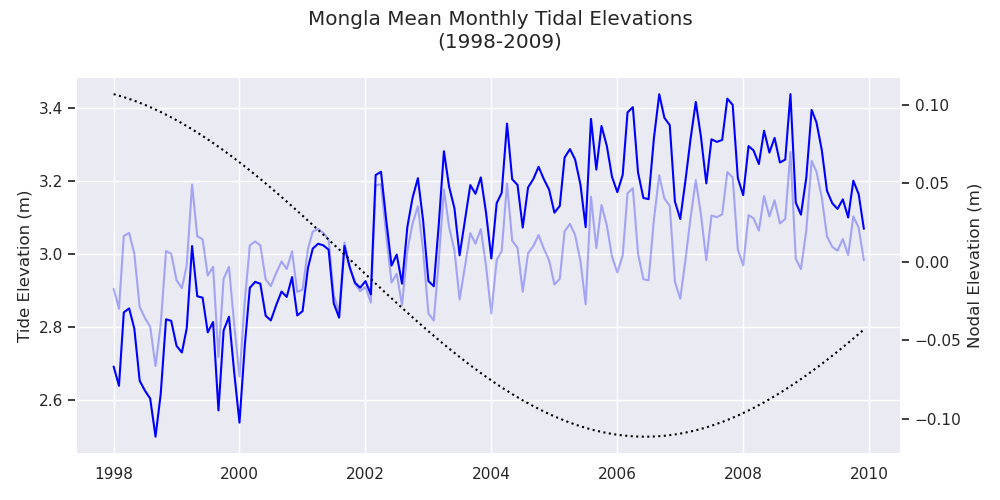

In [124]:
monthly_lm = monthly.apply(lambda x: lm_tides(data=x, ref_date=subset.index[0], time_unit="365.25 days"))

fig = plt.figure(figsize=(10, 5))
ax = fig.subplots()

sns.lineplot(data=monthly.reset_index(), x="datetime", y=monthly.MHW.values - monthly.MLW.values, color="blue", alpha=0.3, ax=ax)
sns.lineplot(data=monthly.reset_index(), x="datetime", y=monthly.MHW_n.values - monthly.MLW_n.values, color="blue", ax=ax)

ax1 = ax.twinx()
sns.lineplot(data=monthly.nodal, color="black", ls=":", ax=ax1, zorder=1, label="Nodal Tide", legend=False)
ax1.set_ylabel("Nodal Elevation (m)")
ax1.grid(False)

ax.set(xlabel="", ylabel="Tide Elevation (m)")

title = "Mongla Mean Monthly Tidal Elevations\n({}-{})".format(subset.index[0].year, subset.index[-1].year)
fig.suptitle(t=title)

fig.tight_layout()

In [35]:
springs = subset.loc[subset.spring == True].apply(
    lambda x: pd.Series(data=(
        subset.loc[subset.high == True].elev_adj.loc[x.name-pd.Timedelta("13.5 hours"):x.name+pd.Timedelta("13.5 hours")].mean(),
        subset.loc[subset.low == True].elev_adj.loc[x.name-pd.Timedelta("13.5 hours"):x.name+pd.Timedelta("13.5 hours")].mean()),
        index=("high", "low")),
        axis=1)

neaps = subset.loc[subset.neap == True].apply(
    lambda x: pd.Series(data=(
        subset.loc[subset.high == True].elev_adj.loc[x.name-pd.Timedelta("13.5 hours"):x.name+pd.Timedelta("13.5 hours")].mean(),
        subset.loc[subset.low == True].elev_adj.loc[x.name-pd.Timedelta("13.5 hours"):x.name+pd.Timedelta("13.5 hours")].mean()),
        index=("high", "low")),
        axis=1)

In [36]:
spring_lm = springs.dropna().apply(lambda x: lm_tides(data=x, ref_date=subset.index[0], time_unit="365.25 days"))
neap_lm = neaps.dropna().apply(lambda x: lm_tides(data=x, ref_date=subset.index[0], time_unit="365.25 days"))

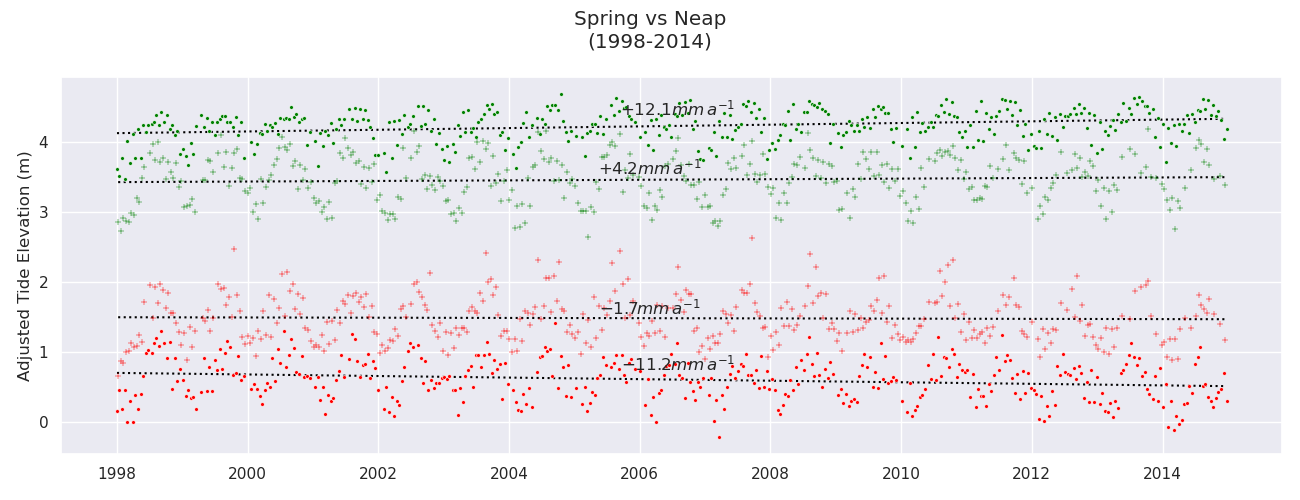

In [37]:
fig = plt.figure(figsize=(13, 5))
ax = fig.subplots()

sns.scatterplot(data=springs.reset_index(), x="datetime", y="high", color="green", marker=".", s=30, ax=ax, zorder=15)
sns.scatterplot(data=neaps.reset_index(), x="datetime", y="high", color="green", marker="+", s=20, ax=ax, zorder=15)
sns.scatterplot(data=springs.reset_index(), x="datetime", y="low", color="red", marker=".", s=30, ax=ax, zorder=15)
sns.scatterplot(data=neaps.reset_index(), x="datetime", y="low", color="red", marker="+", s=20, ax=ax, zorder=15)

sns.lineplot(data=spring_lm.high.TS, color="black", linestyle="dotted", ax=ax, zorder=1)
sns.lineplot(data=neap_lm.high.TS, color="black", linestyle="dotted", ax=ax, zorder=1)
sns.lineplot(data=spring_lm.low.TS, color="black", linestyle="dotted", ax=ax, zorder=1)
sns.lineplot(data=neap_lm.low.TS, color="black", linestyle="dotted", ax=ax, zorder=1)

ax.text(x=spring_lm.high.TS.index.mean(), y=spring_lm.high.TS.max(), ha="center", va="bottom", zorder=30, s="${:+.1f} mm \, a^{{-1}}$".format(spring_lm.high.coef * 1000), fontsize="medium")
ax.text(x=neap_lm.high.TS.index.mean(), y=neap_lm.high.TS.max(), ha="center", va="bottom", zorder=20, s="${:+.1f} mm \, a^{{-1}}$".format(neap_lm.high.coef * 1000), fontsize="medium")
ax.text(x=spring_lm.low.TS.index.mean(), y=spring_lm.low.TS.max(), ha="center", va="bottom", zorder=30, s="${:+.1f} mm \, a^{{-1}}$".format(spring_lm.low.coef * 1000), fontsize="medium")
ax.text(x=neap_lm.low.TS.index.mean(), y=neap_lm.low.TS.max(), ha="center", va="bottom", zorder=20, s="${:+.1f} mm \, a^{{-1}}$".format(neap_lm.low.coef * 1000), fontsize="medium")

ax.set(xlabel="", ylabel="Adjusted Tide Elevation (m)")

title = "Spring vs Neap\n({}-{})".format(subset.index[0].year, subset.index[-1].year)
fig.suptitle(t=title)

fig.tight_layout()

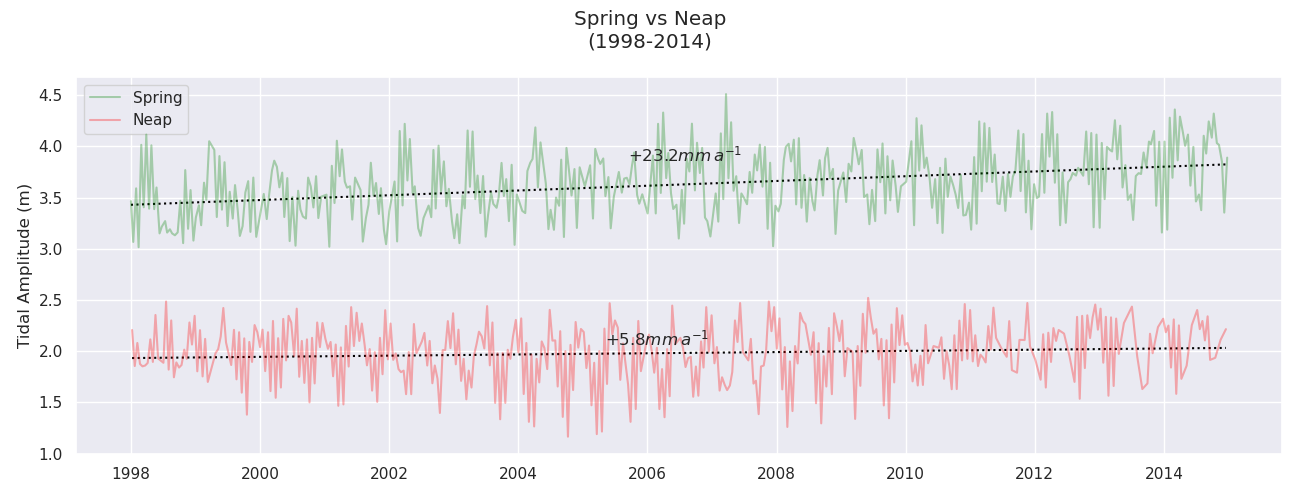

In [40]:
fig = plt.figure(figsize=(13, 5))
ax = fig.subplots()

spring_amp = (springs.high - springs.low).dropna()
neap_amp = (neaps.high - neaps.low).dropna()

spring_amp_lm = lm_tides(data=spring_amp, ref_date=subset.index[0], time_unit="365.25 days")
neap_amp_lm = lm_tides(data=neap_amp, ref_date=subset.index[0], time_unit="365.25 days")

sns.lineplot(data=spring_amp, color="green", alpha=0.3, ax=ax, zorder=15, label="Spring")
sns.lineplot(data=neap_amp, color="red", alpha=0.3, ax=ax, zorder=15, label="Neap")

sns.lineplot(data=spring_amp_lm.TS, color="black", linestyle="dotted", ax=ax, zorder=1)
sns.lineplot(data=neap_amp_lm.TS, color="black", linestyle="dotted", ax=ax, zorder=1)

ax.text(x=spring_amp_lm.TS.index.mean(), y=spring_amp_lm.TS.max(), ha="center", va="bottom", zorder=30, s="${:+.1f} mm \, a^{{-1}}$".format(spring_amp_lm.coef * 1000), fontsize="medium")
ax.text(x=neap_amp_lm.TS.index.mean(), y=neap_amp_lm.TS.max(), ha="center", va="bottom", zorder=20, s="${:+.1f} mm \, a^{{-1}}$".format(neap_amp_lm.coef * 1000), fontsize="medium")

ax.set(xlabel="", ylabel="Tidal Amplitude (m)")

title = "Spring vs Neap\n({}-{})".format(subset.index[0].year, subset.index[-1].year)
fig.suptitle(t=title)

fig.tight_layout()

In [21]:
spring_lm

,high,low
lm,LinearRegression(),LinearRegression()
coef,0.011947,-0.013268
intercept,4.130712,0.712696
TS,datetime 1998-01-01 07:30:00 4.130722 1998-...,datetime 1998-01-01 07:30:00 0.712685 1998-...


In [22]:
neap_lm

,high,low
lm,LinearRegression(),LinearRegression()
coef,0.003932,-0.004099
intercept,3.430805,1.510561
TS,datetime 1998-01-07 21:00:00 3.430879 1998-...,datetime 1998-01-07 21:00:00 1.510484 1998-...
